<a href="https://colab.research.google.com/github/vanislekahuna/Statistical-Rethinking-PyMC/blob/main/Chp_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ch 2 - Small Worlds and Large Worlds**

<img src="https://jewishreviewofbooks.com/wp-content/uploads/2022/09/Nadler_FB_Twitter-1024x512-1.jpg" width=1024 height=512>

[Source](https://jewishreviewofbooks.com/jewish-history/12566/the-golem-of-montreal/#)

## Intro

All statistical models operate within a *small world* and a *large world*.
1. The **small world** is the self-contained logical world with which the model operates, where there are no pure surprises. In the small world, verifying the model's logic is essential to ensure it preforms as intended under favourable assumptions of the larger world.
2. The **large world** is the real world where events take place that may not have been imagined in the small world. In this world, there's no guarantee that the model will operate with the same logical consistency as it did in the small world.

The chapter will focus on the small world using probability theory in its essential form, which is to count all the ways things can happen.

In [ ]:
import math
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

## *Section 2.1* - The garden of forking data

Source: [Statistical Rethinking Fall 2017 - week01 lecture02](https://www.youtube.com/watch?v=IFRAKBArIyM&list=PLDcUM9US4XdM9_N6XUUFrhghGJ4K25bFc&index=2)

*Watch the demonstration from  01:25-16:00*

In the example below, let's say we had a bag of four marbles that could either be blue or white. *Our goal with this demonstration is to figure out the most likely combination of blue and white marbles in the bag, GIVEN that we drew a sequence of blue, white, and blue marbles with replacement* ( \[o, x, o\]). How should we go about this?

**Bayesian Inference** is a garden of forking data where we need to consider everything that *could've* happened, so that we can make a good inference about what *actually* happens. In another sense, Bayesian inference is simply a logical answer to a question in the form of a model.

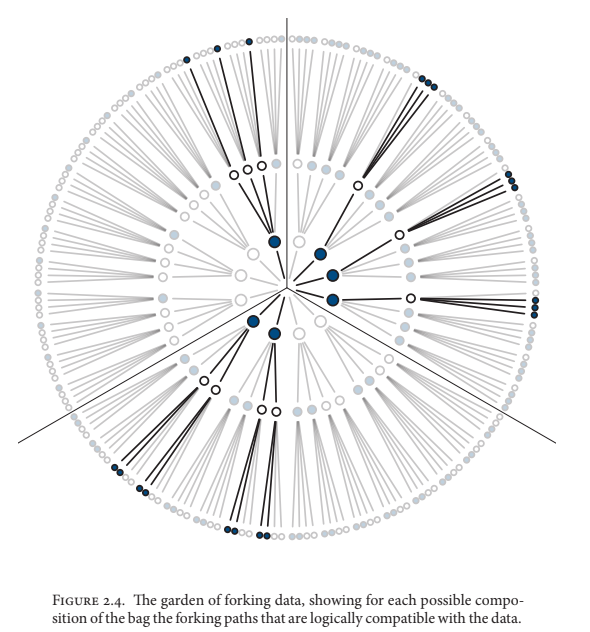

In [ ]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

#### Code 2.1

**Counts to Plausability**

| Conjecture | *p* of o (i.e. choosing blue: o) | blue | white (i.e. x) | blue | ways to produce data (i.e B, W, B) | *plausability* $( {N_{ways} \over N_{total}} )$ | Probability of outcome from composition |
| -------------------- | -------- | ------------------------------ | -------| -------------- | --- | --- | --- |
| [ x x x x ] | 0 | 0 | 0 | 0 | 0 |  0 |  0 |  0 |
| [ o x x x ] | 0.25 | 1 | 3 | 1 | $3 = 1 \times 3 \times 1$ | ${3 \over 20} = $ 0.15| ${ 3 \over 192} = 0.015$ |
| [ o o x x ] | 0.5 | 2 | 2 | 2 | $8 = 2 \times 2 \times 2$ | ${8 \over 20} =$ 0.40 | ${ 8 \over 192} = 0.042$ |
| [ o o o x ] | 0.75 |  3 | 1 | 3 | $9 = 3 \times 1 \times 3 $ | ${9 \over 20} = $ 0.45 | ${9 \over 192} = 0.047$ |
| [ o o o o ] | 0 | 0 | 0 | 0 | 0 | 0 | 0 |

The Total Forking Paths for *each* Blue/White/Blue Conjecture: $4 \times 4 \times 4 = 64$

The Total Forking Paths for *all* Blue/White/Blue Conjectures: $64 \times 3 =$ *192*

In [ ]:
ways = np.array([0, 3, 8, 9, 0])
total_ways = ways.sum()
print(ways / total_ways)  # i.e. [0,3,8,9,0] / 20
print(f"Total Forking Paths: {4**3 * 3}")

From our code simulation, it seems that be conjecture of \[o o o x\] is the most likely conjecture to produce a Blue, White, Blue combination of marbles in that sequence with a total of $9$ ways to create the following outcome.

Another way to re-phrase this in Bayesian terms is that the conjecture of \[o o o x\] (3 blue/1 white) in the bag is the most plausible way (0.45) way to produce our desired outcome out of ALL THE TOTAL ways it could have been produced ($N_{total} = 20$).

#### *Updating our Prior Probability*

Now let's say we decided to draw one more marble, which turned out to be *white*. How would that information change our answer about the most likely combination of marbles in the bag? Instead of re-doing our Garden of Forking data, we can *update our priors* by multiplying them with all the ways to produce white from the given combination (which we can term as the new *evidence*). The table below demonstrates how the additional drawing of white changes the previous table.

<br>

| Conjecture | *p* of o (i.e. choosing blue) | blue | white | blue | ways to produce data (i.e B, W, B) | *plausability* $( {N_{ways} \over N_{total}} )$ | Probability of outcome from composition | $N_{ways}$ of choosing white | *New* way to produce data (i.e B, W, B, (+W)) |
| -------------------- | -------- | ------------------------------ | -------| -------------- | --- | --- | --- | ----------------------- | ----------------- |
| [ x x x x ] | 0 | 0 | 0 | 0 | 0 |  0 |  0 | 0 | 0 |
| [ o x x x ] | 0.25 | 1 | 3 | 1 | $3 = 1 \times 3 \times 1$ | ${3 \over 20} =$ 0.15 | ${ 3 \over 192} = 0.015$ | 3 | $9 = 1 \times 3 \times 1 ( \times 3)$ |
| [ o o x x ] | 0.5 | 2 | 2 | 2 | $8 = 2 \times 2 \times 2$ | ${8 \over 20} =$ 0.40 | ${ 8 \over 192} = 0.042$ | 2 | $16 = 2 \times 2 \times 2 ( \times 2 )$ |
| [ o o o x ] | 0.75 |  3 | 1 | 3 | $9 = 3 \times 1 \times 3 $ | ${9 \over 20} =$ 0.45 | ${9 \over 192} = 0.047$ | 1 | $9 = 3 \times 1 \times 3 ( \times 1 )$ |
| [ o o o o ] | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |


The Total Forking Paths for *each* Blue/White Conjecture: $4^{4} = 256$

The Total Forking Paths for *all* Blue/White Conjectures: $256 \times 3 =$ *768*

<br>

Given that we just drew white in our 4th draw (with replacement), we can now say that the combination of two blue and two white marbles in a bag is the conjecture that's most likely to produce a sequence of drawing with replacement, blue, white, blue, and white.

## *Section 2.2* - Building a model


*Note*: There are 3 general rules in **probability** which is imperative to keep in mind when designing a data story or constructing a model:
- **The Law of Total Probability**: The outcome of all events must eventually equal 1.
- **The Product Rule**: Events that happen TOGETHER must be multiplied.
- **The Sum Rule**: Events that happen ALTERNATIVELY need to be added together.

#### Code 2.2

When constructing a Bayesian model, it's vital to make some assumptions that constitute the model's logic. Designing a simple Bayesian model involves the following 3 steps:


1. A *Data Story* (Designing the model).
- In Bayesian Data Analysis, a **story** is vital in hypothesizing how the data came to be. It can either be *descriptive* or *causal* which describes a theory of how some events produce other events or a mix of both techniques. You can even go as far as using a story to explain how each data point came to be. This process then leads to hypothesizing aspects of the data's underlying reality and the sampling process involved.
- Even if you'll likely abandon a story when building a model, the story still has value in helping you think about additional questions that must be answered about your model when constructing your story.
  - For example, rather than coming up with a vague hypothesis that "it's more likely to rain during warm days," constructing a data story forces you to consider the elements behind the data, such as the measurement and sampling methods or any extraneous variables.
- *The key point to remember in data storytelling is to translate the data story into probability statements, as in section 2.3.1.*

2. *Bayesian Updating* (Condition the data).
- As demonstrated in our earlier example with the marble bags, the learning process of:

    A) Assigning initial probabilities to each set of possibilities,

    B) Then updating these probabilities as we gain information resulting in what we call *posterior probabilities* is a process called **Bayesian Updating**.
  - There's a superstition amongst researchers that we must gather a minimum of 30 observations in order to have a proper statistical estimate/Gaussian distribution in the dataset, which will reveal the data's underlying behaviour (sometimes called *asymptotic behaviour*). With non-Bayesian methods, datasets with less than 30 observations are often discarded as they're considered unreliable sources of truth.
  - In Bayesian statistics, estimates are valid for any sample size because they have a clear and valid interpretation. However, a smaller sample size comes with an increased reliance on forming strong priors, which can cause misleading inferences if it's a bad one.
- Both approaches come with a tradeoff when it comes to small sample sizes. Either you create a Bayesian model with problematic priors, OR you run into difficulties in choosing an estimator should you select the non-Bayesian route.

3. *Evaluation* (Critique the model).
- Bayesian models guarantee perfect inference in the small world. However, it's still essential to *supervise* the model/golem's updating process as it evaluates more data because of the **assumptions** it starts taking on. With the earlier example of the marbles, our golem *assumed* that the order in which we got our results (i.e. B, W, B, W) didn't matter (rightfully so) as long as the ratio's between blue and white marbles remained. However, with some datasets, the order may matter, so it's up to the golem engineer to remain vigilant of these circumstances. It's important to ask (and answer) questions beyond those initially constructed for the model to answer if we're to discover the truth within the scientific context we operate in. Some of the questions one can ask when supervising a golem's training are:
  - Whether the golem malfunctioned?
  - Did the golem's answer make sense within the context of the question you're trying to answer?
  - Did the question itself even make sense?
  - How sensitive are the golem's answers when the assumptions surrounding it change?

## *Section 2.3* - Components of a model


To revisit the beginning of our marble thought experiment, we made certain assumptions in our Data Story, which we can formalize as:
1. Every toss is independent of one another, and
2. Each outcome has the same chance of occurring, regardless of the iteration

These two assumptions both make up characteristics that's commonly termed in statistics as ***Independent and Identically Distributed (i.i.d)***


In [ ]:
# The binomial probability mass function for set of marbles with 2 B's and 2 W's

stats.binom.pmf(2, n=4, p=0.5)

Referring to the [Globe Tossing Experiment](https://youtu.be/IFRAKBArIyM) (19:00-35:55), our scientific question for this experiment is to:

*Determine whether we can use the toy globe in the example to estimate the real-world proportion of land-to-water on Earth based on where our index finger lands every time we catch the globe.*

Therefore, the data story behind the model to explain how data came to be is as follows:
- There is some true proportion of water that we must, which we'll symbolize with $p$ to represent our **parameter** (we can also call it our initial assumption or our **prior**),
- If we toss the globe enough times, we can eventually find $p$ through the probability of observing water (W) and land (L) by $1-p$
- Each toss is **i.i.d**.

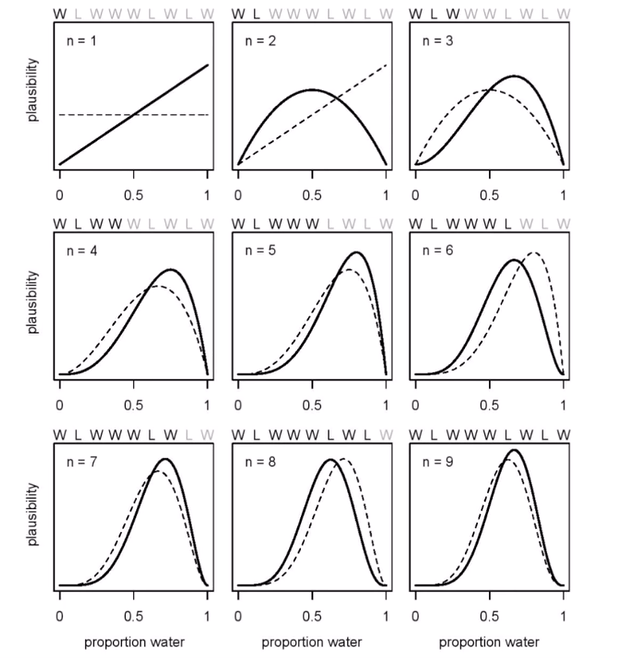

*Figure 2.5. Above is a visualization of Bayesian Updating (or Bayesian Conditioning) in the Globe Tossing Experiment in real-time with zero priors. The dotted line represents the model's prior. In contrast, the solid line represents its posterior probability which then becomes the prior in each iteration of data fed to the model to trigger the Bayesian updating. Observe how the model changes its likelihood distribution with each incoming data point that triggers the Bayesian updating. Also, note that the true proportion of water-to-land on Earth is about [70/30](https://phys.org/news/2014-12-percent-earth.html) ($p = 0.71$). From the graph, we can already see that from iterations 6-9, the probability distribution (or plausibility) starts to center around the 0.7 mark on the x-axis and begins to steepen as the data further solidifies this hypothesis/belief.*

Once we add in our assumption of the globe toss being *i.i.d*, the model will produce a unique answer known as a **binomial distribution** (also known as the "coin tossing" distribution) due to its inherent property of having only two possible outcomes. Therefore, we can formalize this process using the following equation to represent the *probability of observing the outcome of 6 waters ($w = 6$) and 3 land ($l = 3$), given the probability of water ($p = 0.5$) on each toss* is:

<br>

$P(w, l \mid p) = \frac{(w + l)!}{w!l!}p^w (1 - p)^l$

$P(w, l \mid p) = \frac{(6 + 3)!}{6!3!}0.5^6 (1 - 0.5)^3$

$P(w, l \mid p) = \frac{362880}{4320}(0.15625 \times 0.5^3)$

$P(w, l \mid p) = 84 \times 0.001953125$

$P(w, l \mid p) = 0.164 $

In [ ]:
#@title
print("Displaying the results of the mathematical calculations for the equation above... \n")

# Left-hand side Fraction
print("Printing the left-hand side Fraction:")
print(f"Numerator: (w + l)! = 9! = {math.factorial((6 + 3))}")
print(f"Denominator: w!l! = {math.factorial(6)} x {math.factorial(3)} = {math.factorial(6) * math.factorial(3)}")
print(f"Quotient:(w + l)! / w!l! = {math.factorial((6 + 3)) / (math.factorial(6) * math.factorial(3))} \n\n")

# Right-hand side Product
print("Printing the right-hand side Product:")
print(f"Water exponent: p^w = 0.5^6 = {0.5**6}")
print(f"Land exponent: (1 - p)^l = (1 - 0.5)^3 = {(1 - 0.5)**3}")
print(f"Product of the Water and Land exponents: p^w x (1 - p)^l = {(0.5**6) * (1 - 0.5)**3} \n\n")

# Putting it all together
print(f"The probability of observing the given conjecture (6 W's and 3 L's): \n \
((w + l)! / w!l!) x (p^w x (1 - p)^l) = \
{(math.factorial((6 + 3)) / (math.factorial(6) * math.factorial(3))) * ((0.5**6) * (1 - 0.5)**3)}")

Another way to write this equation, keeping in mind that $N$ represents the total outcomes between our index finger landing on either water or land ($N = w + p$), is the following:

$$Pr(w, l \mid p) =  \frac{N!}{w!(N − w)!} p^w (1 − p)^{N−w}$$


The probability of observing 6 W’s in 9 tosses with a value of $p=0.5$ is $0.164$. In terms of code, the `stats.binom.pmf()` function in the `scipy` package is one tools we can use to automatically calculate the likelihood of a given conjecture where there can only be two outcomes associated with it (i.e. Binomially Distributed).

In [ ]:
# Using the scipy "stats" Python package to automatically solve this equation.

stats.binom.pmf(6, n=9, p=0.5) #pmf stands for "Probability Mass Function"

To reiterate, the resulting value $0.164$ represents the probability of observing the conjecture of 6 waters and 3 lands, given that the probability of sampling water is $p = 0.5$. So one question you might ask is how we determined the value of $p$, otherwise known as a **parameter**?

<br>

To reiterate, **parameters** are things we want to estimate the value of. Since there are only two possible outcomes from the globe toss, either water or land, we can arbitrarily assign both outcomes with an equal chance of occurring, similar to that of a coin toss 50/50. Therefore, in this instance, our **prior** is $p = 0.5$. But as we saw in *Figure 2.5*, eventually, our golem will take on a new prior as we feed it data to learn from.

However, priors that are implausible are $p = 0 | 1$ because we know that the world is neither totally water nor totally land. Also, note that there is no such thing as a "true" prior because it simply represents our model's state of information, which is also called a **category error**. You'll often want to embody your model with a state of information that is conservative in order to guard against certain inferential risks. The "truth" is not what's relevant here. Its the risk of taking action from the model is what matters.

These warnings are equally true for **likelihoods** which are a prior distribution you assign to a dataset and have all the same inferential issues. Your likelihood (or priors) don't have to look similar to what will eventually become your posterior when you initially choose them because your model should be able to learn.

## *Section 2.4* - Making the model go!!!


Once we've named all our variables, we'll find that for every combination of *our data, likelihood, parameters, and prior distributions*; there is a unique resulting posterior distribution. The **posterior distribution** takes on the form of the probability of the parameters, conditional on the data. In our previous example, we can symbolize the posterior distribution as $P(p \mid w, l)$, which reads as the probability of each possible value (or the probability of the globe landing on water), given the specific conjecture of $w$ and $l$ observed.

Recap on the important features of Bayesian inference:
- **Data**: The particular conjecture of outcomes that's presented to us.
- **Likelihood**: The probaility/likelihood of that particular conjecture of data, often represented as the **inverse probaility** or the **probability of the data** $P(E | H)$ in Bayes' Theorem. For example, the probability of observing 6 W's in 9 Tosses in the globe tossing experiment given our hypothesis that they have an equal chance ocurring \($0.5$\).
- **Parameters**: The value we want to estimate, often representing the **prior** $P(H)$ in Bayes' Theorem. For example going back to the Globe Tossing Experiment, we initialized our model with there being a 50/50 chance of the globe landing in either water or land. However as we increase our sample size (let's say 1000 tosses), our model updates towards a parameter which more accurately represents the true ratio between water-to-land which is roughly $0.71$ (i.e. our index finger will land on water in approximate 710 of those tosses).
- **Marginal/Average Likelihood** $P(E)$: See below.
- **Posterior**: This value is what we're trying to estimate for and represents the output of our model's learning process which then becomes the *prior* in the next iteration.  


**Bayes Theorem** is the fundamental building block for Bayesian Analysis, which itself is an implication/extension of **probability theory**. In this next section, we'll use probability theory to demonstrate Bayesian updating, despite any change in the value we assign to $p$. Below, we'll examine the **joint probability** of any conjecture of $w$ or $l$ (the data), along with any particular value of $p$:

<br>

$Pr(w, l, p) = Pr(w, l \mid p) \cdot Pr(p) $

<br>

The above formula reads as: *the probability of $w$, $l$, and $p$ equals the product of the probability of the given conjecture of $w$ and $l$, given $p$, AND the probability of $p$*.

This equation is like saying that the probability that it's rainy and cold on the *same* day is equal to the probability of rain *given* that it's a cold day multiplied by the probability that it gets cold in the area you're referring to.

<br>

$ Pr(r, c) = Pr(r \mid c) \cdot Pr(c)$

$ \propto Pr(r, c) = Pr(c \mid r) \cdot Pr(r)$

<br>


We can also get the same result by reversing which probability is conditional, as in the example above. For example, to calculate the probability that it's both rainy and cold on the same day, we can instead multiply the probability of a cold day, given that it's raining, with the probability of rain in the particular area.

Since we've established that

$ Pr(p \mid w, l) \cdot Pr(w, l) = Pr(w, l \mid p) \cdot Pr(p) $

We can then move the variables around so that we're solving for the **posterior distribution**, $P(p \mid w, l)$, which is what we were initially interested in. By rearranging the variables and solving for the posterior probability/distribution, we've now written the formula for Bayes Theorem. To put it into words, we can describe **Bayes Theorem** as the following: The probability of a value of $p$, given a particular conjecture of the data ($P(p \mid w, l)$), is equal to the product of the prior probability ($Pr(p)$) and the probability of that conjecture of the data, given $p$, ($Pr(w, l \mid p)$) divided by what we'll term as the *average probability of the data*. In other books, this term is often used synonymously as the probability of the evidence, $P(E)$, or the *marginal likelihood* and the *average likelihood*.

<br>

$P(p \mid w, l) = \frac{Pr(p) \cdot Pr(w, l \mid p)}{Pr(w, l)} = \frac{Prior \times probability \cdot of \cdot the \cdot data (Likelihood)}{Avg \cdot probability \cdot of \cdot the \cdot data (Avg \cdot likelihood)} = Posterior$

<br>

To get more in-depth with the **marginal likelihood**, it simply represents the *average* probability of the data over the prior. Its job is to standardize the posterior and make sure it sums (integrates) to 1. You can calculate the marginal likelihood of data with a **Binomial Distribution** (two outcomes, heads/tails, water/land) by adding the numerator ($Pr(p) \cdot Pr(w, l \mid p)$) with the product of its counterfactual.

So, for example, if the probability of the globe landing on water is ($Pr(p) = 0.6$), then the probability of the opposite happening, which is the globe landing on land, is ($Pr(p^-) = 0.4$). Alternatively, if the probability of data, given the Prior is ($Pr(w, l \mid p) = 0.164$), then the probability of the data given that the prior's alternative is ($Pr(w, l \mid p^-) = 1 - 0.164 =  0.836$). *The following equation summarizes our explanation of **marginal likelihood** in the context of Bayesian Statistics and applies **Bayes Theorem** to the example of discovering the posterior probability of our Globe-Tossing Experiment*:

<br>

$ Bayes \cdot Theorem = \frac{Pr(H) \times Pr(E \mid H)}{Pr(E)} = \frac{Pr(H) \times Pr(E \mid H)}{(Pr(H) \times Pr(E \mid H)) + (Pr(H^-) \times Pr(E \mid H^-))} $

<br>

$ P(p \mid w, l) = \frac{Pr(p) \cdot Pr(w, l \mid p)}{Pr(w, l)} = \frac{Pr(p) \cdot Pr(w, l \mid p)}{(Pr(p) \cdot Pr(w, l \mid p)) + ((1 - Pr(p)) \cdot (1 - Pr(w, l \mid p)))} = \frac{0.6 \times 0.164}{(0.6 \times 0.164) + (0.4 \times 0.836)} = \frac{0.0984}{0.4328} $

<br>

$ P(p \mid w, l) = 0.2273$

<br>


Note that the *integral* defines the proper way to compute the average over a continuous distribution of values, such as $p$:

$Pr(w,l) = E(Pr(w, l \mid p)) = \int Pr(w, l \mid p) \cdot Pr(p) \cdot dp $

Also, one thing to remember is that the posterior is proportional to the prior multiplied by the likelihood, which stems from conditional probability.

<br>

vvv

$Prior \times Likelihood \propto Posterior$

^^^

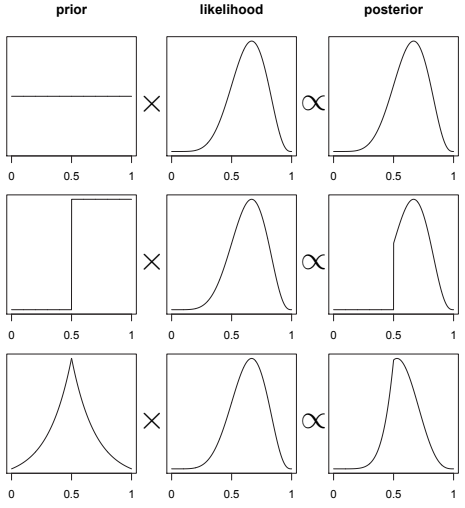

*Figure 2.6. These graphs illustrate how the posterior is essentially a product of the prior and the likelihood.*

*On Row 1, we'll find flat prior where all values of $p$ have an equal chance of occurring, multiplied by a likelihood that assigns a higher probability to values hovering around 0.7, producing a posterior that mirrors the likelihood. In other words, our prior basically didn't contain any information, so when we conditioned the model with the likelihood, the model's posterior then copied the likelihood because it was the only variable that contained information.*

*In Row 2, the prior assigns a 0% chance that any $p$ value below 0.5 has any chance of occurring, which then reflects on our posterior.*

*On Row 3, our prior indicates that values closest to a $p$ value of 0.5 have the highest chance of occurring, which therefore causes our posterior distribution to shift left to hover closer to 0.5. It also shows how quickly the priors in a dataset wash out as we feed our model with data and force it to update its priors.*

#### **2.4.2. Motors**.

Recall that a Bayesian model is a machine, or a figurative golem, with built-in definitions for the likelihood, the parameters, and the prior. If we continue expanding this metaphor, we can then consider its heart to be a *motor* that *conditions* the prior to the data it's fed, producing a posterior distribution.

In Bayesian analysis, there are various **conditioning engines** which can accommodate whichever prior is most useful for inference. In addition, there are many numerical techniques for computing posterior distributions, with new ones being invented all the time. However, the 3 that we'll touch on in this chapter are:

1. Grid approximation
2. Quadratic approximation.
3. Markov chain Monte Carlo (MCMC).

#### **2.4.2.1 Grid Approximation**.

One of the most straightforward conditioning techniques is known as **grid approximation**, which only considers a finite grid of parameter values and calculates the posterior probability by multiplying a given parameter's ($p'$) prior probability with its likelihood. If we repeat this procedure for each value in the grid, we'll generate an approximate picture of the exact posterior distribution.

However, the downside to grid approximation is that it isn't always practical because it scales poorly as the number of parameters increases. Regardless, we can still attain a good understanding of the nature of Bayesian updating by implementing this technique in code.

Below is the algorithm for building a grid approximation for our Bayesian model:

1. *Define the grid*, which means deciding how many points to use in estimating the posterior before making a list of the parameter values on the grid.
2. *Compute the value of the **prior** at each parameter value on the grid.*
3. *Compute the **likelihood** at each parameter value.*
4. *Multiply the prior by the likelihood to calculate the unstandardized posterior at each parameter value.*
5. *Standardize the posterior by dividing each value by the sum of all the values.*

Formula for **Grid Approximation**:

$ P(p | w, l) = \frac{P(p_{i}) \cdot P(w_{i}, l_{i} | p_{i})}{\sum\limits_{i=1}^n{P(p_{i}) \cdot P(w_{i}, l_{i} | p_{i})}} $

#### Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In the book, the following code is not inside a function, but this way it is easier to play with different parameters.

In [ ]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(5, grid_points)


def truncated_prior(grid_points, trunc_point=0.5):
    """
    Returns Truncated prior density

            Parameters:
                grid_points (numpy.array): Array of prior values
                trunc_point (double): Value where the prior is truncated

            Returns:
                density (numpy.array): Truncated density of prior values
    """
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)


def double_exp_prior(grid_points):
    """
    Returns Double Exponential prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Double Exponential density of prior values
    """
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

In [ ]:
def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    successes (int): Number of successes
                    tosses (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum() # i.e. Pretty much Bayes Theorem in its most basic form minus the "sum" instead of avg.
    return p_grid, posterior

#### Code 2.3

In [ ]:
# Conjecture for the Globe Tossing Experiment.
w, n = 6, 9

points = [5, 20, 100]

_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(uniform_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water ($p$ = prior)")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

In [ ]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(truncated_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

In [ ]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(double_exp_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

#### **2.4.2.2 Quadratic Approximation**.

As we mentioned earlier, one of the problems with grid approximation is achieving scale, which will force us to use another approximation technique with stronger assumptions. The reason why grid approximation has trouble with scale is because the number of unique values your model has to consider will grow exponentially as the number of parameters in your model increases. With the globe-tossing experiment, grid approximation works just fine because we only have a single parameter to deal with: the probability of water ($p$), and up to 5, 20, or 100 individual data points. However, if we had a model with even just *two parameters* and 100 values, that already becomes $100^2 = 10,000$ values to compute in our model. Imagine if we had a model with hundreds, or even thousands, of parameters which are not uncommon in today's age of cheap computing and artificial intelligence. You can see how unsustainable this problem is becoming.

Therefore, enter quadratic approximation as a solution to address these scaling issues. As a conditioning engine that conditions the prior to the data, the goal of **quadratic approximation** is to focus on the area near the peak of a posterior distribution. We only want to focus on the peak because, under general conditions, the region surrounding it is normally **Gaussian** (i.e. "normal") in shape. Therefore, we can characterize the posterior distributions' "peak" with only two numbers: the *mean*, which is the location of its center, and its *variance*, which describes the spread of the distribution. Since we magnify our focus on a Gaussian peak with this conditioning engine, a quadratic approximation is sometimes called **Gaussian approximation** because of how the logarithm forms a parabola, which is also a quadratic function.

This approximation can work very well in applied statistics, such as with linear regression, and can sometimes produce a result that is exactly correct - not an approximation at all. In summary, this quadratic approximation essentially represents any log-posterior with a parabola.

We can describe the algorithm for embedding a quadratic approximation in our Bayesian golem as the following:

1. *Find the posterior mode which we can also call the **maximum a priori (MAP)**.* This is usually accomplished by some optimization algorithm that virtually "climbs" to the top of a posterior distribution as if it were a mountain. Optimization algorithms often don't know where the peak is in a posterior distribution—however, it's good at calculating the slope underneath its feet, which helps them identify the peak.

 - The default optimaization algorithm for finding the MAP in PyMC is called "L-BFGS-B" which stands for **Limited Memory [Broyden-Fletcher-Goldfarb-Shanno](https://machinelearningmastery.com/bfgs-optimization-in-python/) with Bounds**.

2. *Estimate the curvature of the peak.* This is sufficient for finding the Gaussian approximation of the entire posterior distribution.

*If some of the code doesn't make sense right now, don't lose sleep over it. We will cover the intuition behind some of these libraries in upcoming chapters. For now, it's more important to grasp the broader ideas behind these approximation techniques.*

#### Code 2.6

Computing the posterior using the quadratic approximation (quad).

In [ ]:
data = np.repeat((0, 1), (3, 6)) #6 W's + 3 L's
data

In [ ]:
with pm.Model() as normal_approximation: #NOTE that pm represents "import pymc as pm"
    p = pm.Uniform("p", 0, 1)  # uniform priors, the "p" represents the variable name.
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood,
    mean_q = pm.find_MAP() # The optimization algorithm that tries to find the "peak" of the posterior distribution? (i.e. the mean)
    print(f"mean_q = {mean_q}, \n")

    p_value = normal_approximation.rvs_to_values[p]
    print(f"normal_approximation.rvs_to_values? = {normal_approximation.rvs_to_values}, \n") # The 'p' key here is what's important w/ a value of 'p_interval__'

    p_value.tag.transform = None
    p_value.name = p.name

    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]
    print(f"std_q = {std_q}, \n")

# display summary of quadratic approximation
print("Mean, Standard deviation \n p {:.2}, {:.2}".format(mean_q["p"], std_q[0]))

From the code above, our **quadratic approximation** shows us the posterior mean value of $p = 0.67$, which it calls the "mean," along with the standard deviation of the posterior distribution, which is $0.157$. You can interpret the result as the following: *Assuming that the posterior is Gaussian (or has a normal "bell curve" distribution), the distribution's peak is at 0.67 with a standard deviation of 0.16*.

Standard deviation?: $ 0.16 = \frac{(p - \bar{q})}{2} = \frac{(0.6667 - 0.6368)}{2} $

In [ ]:
# Compute the 89% percentile interval
norm = stats.norm(loc=mean_q, scale=std_q) # Generates a normal distribution based on the mean and st.dev.
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print("5.5%, 94.5% \n{:.2}, {:.2}".format(pi[0], pi[1]))

Note that the function - `scipy.stats.norm` - is meant to return a normal continuous random variable. We can compare it to the `stats.binom.pmf`, which produces a single output based on the parameters you fed it. `norm` only requires two arguments: location (`loc`), which specifies the *mean*, and scale (`scale`) which specifies the *standard deviation*. The probability density function for `norm` is the following equation:

$$f(x) = \frac{exp(-x^2 / 2)}{\sqrt{2\pi}} = \frac{e^{\frac{-x^2}{2}}}{\sqrt{2\pi}}$$

--> Keep in mind that $exp()$ represents an exponential function which can be denoted as $exp(x) = e^x$. As a reminder, $e = 2.71828$ stands for the mathematical constant **Euler's Number**, the base of [natural logarithms](https://en.wikipedia.org/wiki/Natural_logarithm).

#### Code 2.7

With our data, we can also compare the preformance of the **quadratic approximation** with the true posterior if we calculate it **analytically**. One quick note is that quadratic approximation is often equivalent to a non-Bayesian paremeter estimate called **Maximum Likelihood Estimate** and its **Standard Error**. Both these non-Bayesian parameter estimates suffer the identical drawback of being inaccurate with smaller data samples compared to grid approximation (*See Figure 2.8*).

##### Quadratic Approximation vs. Maximum Likelihood Estimate

Let's get briefly into it with these two methods:

**Quadratic approximation** is a method used in statistics and machine learning to approximate the shape of a function or distribution which, in the context of Bayesian Statistics, is often used to approximate the posterior distribution. It involves fitting a quadratic function (a parabola) to the data and using that to make predictions. <p>

On the other hand, **maximum likelihood estimate (MLE)** is a method used in statistics to estimate the parameter values of a probability distribution that maximize the likelihood function. The *likelihood function* in turn is a measure of how well the data fit the distribution. MLE is a point estimate, meaning it gives a single value for each parameter. <p>

**Let's also throw in the concept of **standard error (SE)** which is a measure of the variability of a sampling distribution. It is calculated as the standard deviation of the sample mean. The smaller the SE, the more precise the estimate is. <p>

In summary, quadratic approximation is a method to approximate the shape of a function whereas maximum likelihood estimate is a method to estimate the parameters of a distribution and Standard Error measures the variability of a sampling distribution. One of the main differences between the two is that quadratic approximation focuses on the distrubution itself and can therefore also provide estimation of the model's uncertainty while maximum likelihood estimate focuses on the point estimates of the parameters.
</p>





In [ ]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), label="True posterior")

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {n}")
plt.xlabel("Proportion water");

In [ ]:
# Figure 2.8
x = np.linspace(0, 1, 100)
w, n = [6, 12, 24], [9, 18, 36]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for idx, ps in enumerate(zip(w, n)):
    data = np.repeat((0, 1), (ps[1] - ps[0], ps[0]))
    with pm.Model() as normal_approximation:
        p = pm.Uniform("p", 0, 1)  # uniform priors
        w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
        mean_q = pm.find_MAP()

        p_value = normal_approximation.rvs_to_values[p]
        p_value.tag.transform = None
        p_value.name = p.name

        std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

    ax[idx].plot(x, stats.beta.pdf(x, ps[0] + 1, ps[1] - ps[0] + 1), label="True posterior")
    ax[idx].plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("density")
    ax[idx].set_title(r"$n={}$".format(ps[1]))
    ax[idx].legend(loc="upper left")

#### **2.4.2.3 Markov Chain Monte Carlo**.

Multi-level models are some of the most important models we need to utilize due to the complexity of the data we're trying to analyze. For example, we'll have to rule out grid approximation in highly complex scenarios due to the abovementioned scaling issues. And while we can consider quadratic approximation in special circumstances where the stars align, it's often difficult to use this specific conditioning engine because there isn't often a single unified function to maximize (i.e. finding the MAP) for the posterior distribution.

During instances requiring multi-level models, the family of conditioning engines known as **Markov Chain Monte Carlo (MCMC)** are often the best tools for handling these highly complex models. To provide a quick overview, MCMC uses a non-intuitive strategy of drawing samples from the posterior instead of trying to approximate it, as we saw with the last two engines. As a result, you end up with a *collection* of parameter values and the *frequencies* in which they correspond to the posterior plausibilities. To put it another way, instead of constructing a mathematical estimate of the posterior from the data, MCMC works directly with the samples because they're easier to encapsulate cognitively.

#### Code 2.8

In [ ]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5 #Replaces the first 0 in our array of zeroes with a 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1) # Returns a random decimal which will serve as the prior value
    if p_new < 0:                            # Returns 1 (specified using rvs) normal continuous random variable based on the mean and stdev given in the arguments.
        p_new = -p_new                       # Ensures that our p doesn't have any negative values
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

In [ ]:
# Testing the code

n_samples = 6
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    print(f"p_new before transformation: {p_new}")
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    print(f"p_new after transformation: {p_new}, \n")

    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

In [ ]:
az.plot_kde(p, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend();

In [ ]:
# %load_ext watermark
# %watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Next Lecture: [Statistical Rethinking Fall 2017 - week02 lecture03](https://youtu.be/0biewTNUBP4)